In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, UpSampling2D, Reshape
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

In [2]:
data_folder = "sample_data/"

In [3]:
attr_df = pd.read_csv(data_folder+'attr.csv')
attr_df = attr_df.replace(to_replace = -1, value = 0)

In [4]:
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

In [5]:
def load_dataset(data_dir, img_size = 32, batch_size = 1):
    df = tf.keras.utils.image_dataset_from_directory(directory = data_dir, 
                                                     labels = None, 
                                                     image_size = (img_size, img_size),
                                                     batch_size = batch_size,
                                                     seed = 42
                                                    )
    df = df.map(lambda x : x/255.0)
    df = df.map(lambda x: (x, x))
    return df

In [6]:
img_size = 64
train_ds = load_dataset(data_folder+"img", img_size = img_size, batch_size = 32)

Found 2026 files belonging to 1 classes.


2023-03-22 22:20:14.088942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 22:20:14.136322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 22:20:14.144520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 22:20:14.154763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
def get_prior(num_modes, latent_dim):
    prior = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=[1 / num_modes,] * num_modes),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=tf.Variable(tf.random.normal(shape=[num_modes, latent_dim])),
            scale_diag=tfp.util.TransformedVariable(tf.Variable(tf.ones(shape=[num_modes, latent_dim])), bijector=tfb.Softplus())
        )
    )
    return prior

In [8]:
def get_kl_regularizer(prior_distribution):
    divergence_regularizer = tfpl.KLDivergenceRegularizer(
        prior_distribution,
        use_exact_kl=False,
        weight=1.0,
        test_points_fn=lambda q: q.sample(3),
        test_points_reduce_axis=(0, 1)
    )
    return divergence_regularizer

In [9]:
prior = get_prior(num_modes=2, latent_dim=50)
kl_regularizer = get_kl_regularizer(prior)

In [10]:
def reconstruction_loss(batch_of_images, decoding_dist):
    """
    The function takes batch_of_images (Tensor containing a batch of input images to
    the encoder) and decoding_dist (output distribution of decoder after passing the 
    image batch through the encoder and decoder) as arguments.
    The function should return the scalar average expected reconstruction loss.
    """
    return -tf.reduce_mean(decoding_dist.log_prob(batch_of_images), axis=0)

In [11]:
def get_encoder(latent_dim, kl_regularizer):
    encoder = Sequential([
        Conv2D(32, (4, 4), activation='relu', strides=2, padding='SAME', input_shape=(img_size, img_size, 3)),
        BatchNormalization(),
        Conv2D(64, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Conv2D(128, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Conv2D(256, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Flatten(),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(latent_dim, activity_regularizer=kl_regularizer)
    ])
    return encoder

def get_decoder(latent_dim):
    decoder = Sequential([
        Dense(4096, activation='relu', input_shape=(latent_dim, )),
        Reshape((4, 4, 256)),
        UpSampling2D(size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='SAME'),
        Conv2D(3, (3, 3), padding='SAME'),
        Flatten(),
        tfpl.IndependentBernoulli(event_shape=(img_size, img_size, 3))
    ])
    return decoder

encoder = get_encoder(latent_dim=50, kl_regularizer=kl_regularizer)
decoder = get_decoder(latent_dim=50)
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=reconstruction_loss)

In [12]:
_ = vae.fit(train_ds, epochs=100)

Epoch 1/100


2023-03-22 22:20:23.026012: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


64/64 [==============================] - 13s 77ms/step - loss: 7842.2959
Epoch 2/100
64/64 [==============================] - 5s 69ms/step - loss: 7184.2085
Epoch 3/100
64/64 [==============================] - 4s 69ms/step - loss: 7039.7886
Epoch 4/100
64/64 [==============================] - 5s 69ms/step - loss: 6912.1562
Epoch 5/100
64/64 [==============================] - 5s 69ms/step - loss: 6868.8921
Epoch 6/100
64/64 [==============================] - 5s 69ms/step - loss: 6807.5586
Epoch 7/100
64/64 [==============================] - 5s 69ms/step - loss: 6754.9219
Epoch 8/100
64/64 [==============================] - 6s 86ms/step - loss: 6712.1040
Epoch 9/100
64/64 [==============================] - 5s 70ms/step - loss: 6687.0327
Epoch 10/100
64/64 [==============================] - 4s 69ms/step - loss: 6643.3696
Epoch 11/100
64/64 [==============================] - 4s 68ms/step - loss: 6631.5293
Epoch 12/100
64/64 [==============================] - 5s 69ms/step - loss: 6613.6611


64/64 [==============================] - 4s 68ms/step - loss: 6114.5039
Epoch 98/100
64/64 [==============================] - 4s 68ms/step - loss: 6113.3364
Epoch 99/100
64/64 [==============================] - 4s 68ms/step - loss: 6118.6860
Epoch 100/100
64/64 [==============================] - 5s 83ms/step - loss: 6119.4355


In [13]:
def generate_images(prior, decoder, n_samples):
    """
    The function takes the prior distribution, decoder and number of samples as inputs, which
    should be used to generate the images.
    The function should then return the batch of generated images.
    """
    z = prior.sample(n_samples)
    return decoder(z).mean()

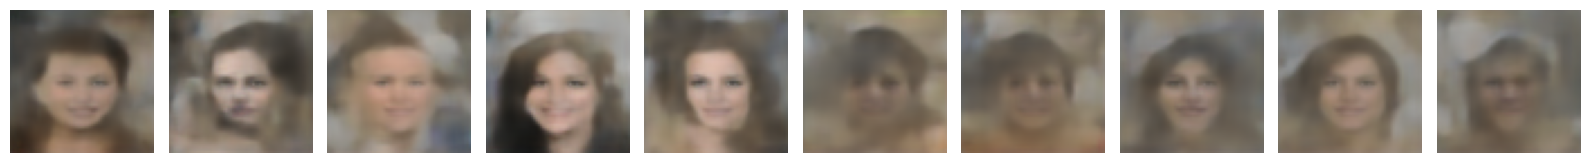

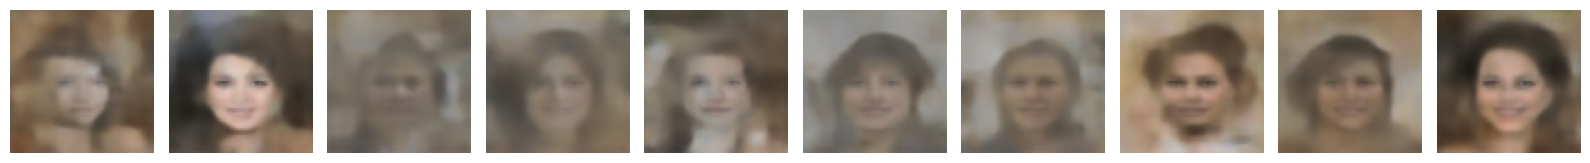

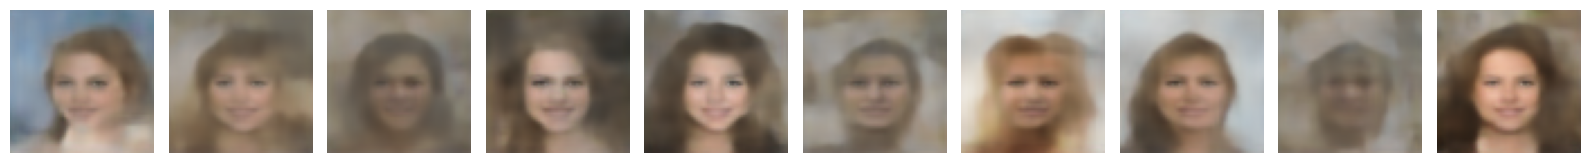

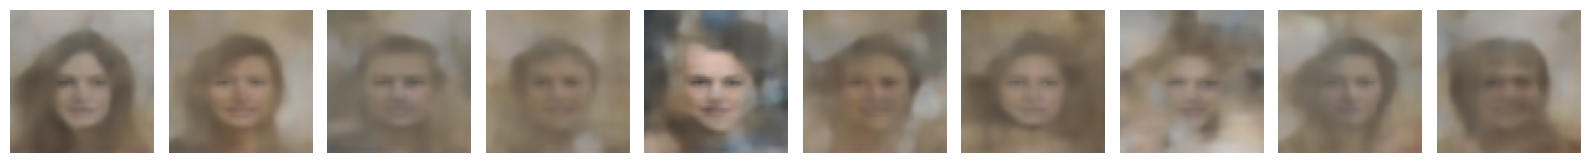

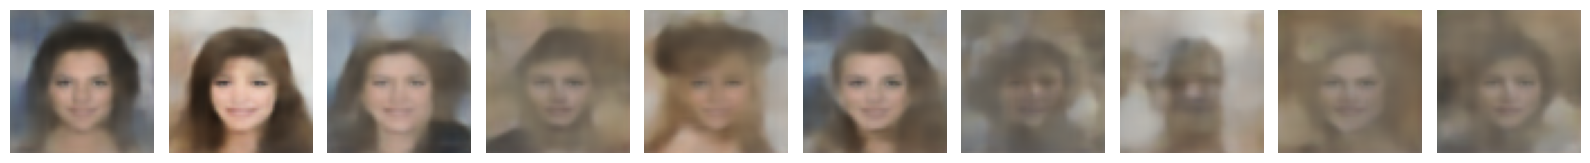

In [14]:
n_samples = 10

for i in range(5):
    f, axs = plt.subplots(1, n_samples, figsize=(16, 6))
    sampled_images = generate_images(prior, decoder, n_samples)
    for j in range(n_samples):
        axs[j].imshow(sampled_images[j])
        axs[j].axis('off')

    plt.tight_layout()